In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

## Data Input

In [ ]:
from google.colab import drive

df_fake = pd.read_csv("/content/drive/MyDrive/ST456-Final-Project/Fake.csv")
df_true = pd.read_csv("/content/drive/MyDrive/ST456-Final-Project/True.csv")

check the dataframe

In [ ]:
len(df_fake)

23481

In [ ]:
len(df_true)

21417

## Data Cleaning

some related libraries and packages for word tokenization

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

some related libraries and packages for word simplification.

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess 
# this package is used to simplify the words, the strings with punctations are removed
# the capital letter is converted from the upper form to lower form
from gensim.parsing.preprocessing import STOPWORDS
# this package is used to add some stopwords which contain 'the', 'and', 'or', etc.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


This is a function for simplifying the text, we only consider the word with length more than 3, because the words with too less length is useless for our text analysis

In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(STOPWORDS) # conbime two stopwords set together
# stop_words.extend(['trump', 'obama', 'clinton'])
def preprocess(text):
    result = []
    for token in simple_preprocess(text): # simplify the word text
        if len(token) > 3 and token not in stop_words: # only consider the word with length more than 3 and not in stopwords list
            result.append(token)
    return result

In [ ]:
df_true_title = df_true['title'].apply(preprocess)
df_fake_title = df_fake['title'].apply(preprocess)
df_true_text = df_true['text'].apply(preprocess)
df_fake_text = df_fake['text'].apply(preprocess)

In [ ]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
#tokenizer = Tokenizer(num_words = true_title_totalword + fake_title_totalword)
tokenizer = Tokenizer(lower=False)
#tokenizer = Tokenizer()
title_X = pd.concat([df_true_title, df_fake_title], axis = 0)
title_Y = np.concatenate((np.ones([len(df_true_title), 1]), np.zeros([len(df_fake_title), 1])), axis = 0)
X_train, X_test, Y_train, Y_test = train_test_split(title_X, title_Y, test_size=0.2, random_state=42)


text1 = list(X_train)
tokenizer.fit_on_texts(text1)
pad_seq1 = pad_sequences(tokenizer.texts_to_sequences(text1), maxlen = 20,  padding='post', value=0)
x_train_title = tf.convert_to_tensor(pad_seq1)
y_train_title = tf.convert_to_tensor(Y_train)

text2 = list(X_test)
tokenizer.fit_on_texts(text2)
pad_seq2 = pad_sequences(tokenizer.texts_to_sequences(text2),maxlen = 20, padding='post', value=0)
x_test_title = tf.convert_to_tensor(pad_seq2)
y_test_title = tf.convert_to_tensor(Y_test)

text_X = pd.concat([df_true_text, df_fake_text], axis = 0)
text_Y = np.concatenate((np.ones([len(df_true_text), 1]), np.zeros([len(df_fake_text), 1])), axis = 0)
X_train, X_test, Y_train, Y_test = train_test_split(text_X, text_Y, test_size=0.2, random_state=42)

text3 = list(X_train)
tokenizer.fit_on_texts(text3)
pad_seq3 = pad_sequences(tokenizer.texts_to_sequences(text3), maxlen = 200, padding='post', value=0)
x_train_text = tf.convert_to_tensor(pad_seq3)
y_train_text = tf.convert_to_tensor(Y_train)

text4 = list(X_test)
tokenizer.fit_on_texts(text4)
pad_seq4 = pad_sequences(tokenizer.texts_to_sequences(text2), maxlen = 200, padding='post', value=0)
x_test_text = tf.convert_to_tensor(pad_seq4)
y_test_text = tf.convert_to_tensor(Y_test)

6B GLoVE Pre-embeddings are downloaded from website https://nlp.stanford.edu/projects/glove/, and the file "glove.6B.100d.txt" is uploaded to the Colab Environment.

In [ ]:
embeddings_dict = {}

#Stores word vectors in an embedding dictionary with corresponding vector values
with open("/content/drive/MyDrive/ST456-Final-Project/glove.6B/glove.6B.100d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [ ]:

# Determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # add 1 for the padding token

# Set the embedding dimension
embedding_dim = 100

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        break
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None and len(embedding_vector) == embedding_dim:
        embedding_matrix[i] = embedding_vector


## CNN Model(Adam: lr = 0.0001, L1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D, Dropout, Bidirectional, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
#Model 2 - 74% lolz
#65% accuracy
#experimental model 
# Define input lengths for titles and texts
max_len1 = 20
max_len2 = 200
vocab_size1 = 20000 #19175
embedding_dim1 = 100
vocab_size2 = 110000 #108259
embedding_dim2 = 200
embedding_dim = 100
num_filters = 128
filter_size = 8
pool_size = 8
dropout_rate = 0.5


# Input for titles
title_input = tf.keras.Input(shape=(max_len1,))
title_embed = tf.keras.layers.Embedding(vocab_size, embedding_dim1, weights=[embedding_matrix], trainable=False)(title_input)
title_conv_1 = tf.keras.layers.Conv1D(32, 4, padding='same', activation='relu')(title_embed)
title_conv_2 = tf.keras.layers.Conv1D(64, 8, padding='same', activation='relu')(title_embed)
title_conv_3 = tf.keras.layers.Conv1D(128, 8, padding='same', activation='relu')(title_embed)

title_pool_1 = tf.keras.layers.MaxPooling1D(pool_size=pool_size)(title_conv_1)
title_pool_2 = tf.keras.layers.MaxPooling1D(pool_size=pool_size)(title_conv_2)
title_pool_3 = tf.keras.layers.MaxPooling1D(pool_size=2)(title_conv_3)

# Resize the inputs to have the same shape
title_pool_1 = tf.keras.layers.GlobalAveragePooling1D()(title_pool_1)
title_pool_2 = tf.keras.layers.GlobalAveragePooling1D()(title_pool_2)
title_pool_3 = tf.keras.layers.GlobalAveragePooling1D()(title_pool_3)

title_merged = tf.keras.layers.concatenate([title_pool_1, title_pool_2, title_pool_3])
title_merged = tf.keras.layers.Reshape((1, -1))(title_merged) 

title_conv = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu')(title_merged)
title_pool = tf.keras.layers.MaxPooling1D(pool_size=1)(title_conv)

title_conv1 = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu')(title_pool)
title_pool1 = tf.keras.layers.MaxPooling1D(pool_size=1)(title_conv1)

title_global_pool = tf.keras.layers.GlobalMaxPooling1D()(title_pool1)
title_drop = tf.keras.layers.Dropout(dropout_rate)(title_global_pool)

# Input for textsx
text_input = tf.keras.Input(shape=(max_len2,))
text_embed = tf.keras.layers.Embedding(vocab_size, embedding_dim1, weights=[embedding_matrix], trainable=False)(text_input)

text_conv_1 = tf.keras.layers.Conv1D(5, 8, padding='same', activation='relu')(text_embed)
text_conv_2 = tf.keras.layers.Conv1D(4, 8, padding='same', activation='relu')(text_embed)
text_conv_3 = tf.keras.layers.Conv1D(3, 4, padding='same', activation='relu')(text_embed)

text_pool_1 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv_1)
text_pool_2 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv_2)
text_pool_3 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv_3)

text_merged = tf.keras.layers.concatenate([text_pool_1, text_pool_2, text_pool_3])

text_conv = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu')(text_merged)
text_pool = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv)

text_conv1 = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu')(text_pool)
text_pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv1)

text_global_pool = tf.keras.layers.GlobalMaxPooling1D()(text_pool1)
text_drop = tf.keras.layers.Dropout(dropout_rate)(text_global_pool)

# Concatenate title and text representations
merged = tf.keras.layers.concatenate([title_drop, text_drop])

# Add additional layers for further processing
merged_dense = tf.keras.layers.Dense(64, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.01))(merged)
merged_drop = tf.keras.layers.Dropout(dropout_rate)(merged_dense)
output = tf.keras.layers.Dense(1, activation='sigmoid')(merged_drop)
# Create the multi-input model
model_cnn = tf.keras.Model(inputs=[title_input, text_input], outputs=output)
model_cnn.summary()

In [ ]:
# model.summary()
dot_img_file = '/content/drive/MyDrive/ST456-Final-Project/model_cnn.png'
tf.keras.utils.plot_model(model_cnn, to_file=dot_img_file, show_shapes=True)

In [ ]:
### Create the multi-input model
model_cnn = tf.keras.Model(inputs=[title_input, text_input], outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) 
model_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn= model_cnn.fit([x_train_title, x_train_text], y_train_text, validation_split = 0.2, epochs=50, batch_size=128)

In [ ]:
print("Accuracy of the model on Testing Data is - " , model_cnn.evaluate([x_test_title, x_test_text], y_test_text)[1]*100 , "%")

In [ ]:
loss_cnn = history_cnn.history['loss']
val_loss_cnn = history_cnn.history['val_loss']
acc_cnn = history_cnn.history['accuracy']
val_acc_cnn = history_cnn.history['val_accuracy']

In [ ]:
epochs = range(1, 51)
plt.clf()
# plt.subplot(location)
plt.plot(epochs, loss_cnn, 'r-o', label='Training loss')
plt.plot(epochs, val_loss_cnn, 'b-o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
epochs = range(1, 51)
plt.clf()
# plt.subplot(location)
plt.plot(epochs, acc_cnn, 'r-o', label='Training accuracy')
plt.plot(epochs, val_acc_cnn, 'b-o', label='Validation accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred_text = model_cnn.predict([x_test_title, x_test_text])
y_pred_text = [1 if x > 0.5 else 0 for x in y_pred_text]
#y_pred_text = [1 if x > 0.0005 else 0 for x in y_pred_text]
accuracy = accuracy_score(y_test_text, y_pred_text)
precision = precision_score(y_test_text, y_pred_text, average='macro')
recall = recall_score(y_test_text, y_pred_text, average='macro')
f1 = f1_score(y_test_text, y_pred_text, average='macro')
confusion = confusion_matrix(y_test_text, y_pred_text)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("Confusion matrix:\n", confusion)

## CNN Model(Adam: lr = 0.001, L1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D, Dropout, Bidirectional, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
#Model 2 - 74% lolz
#65% accuracy
#experimental model 
# Define input lengths for titles and texts
max_len1 = 20
max_len2 = 200
vocab_size1 = 20000 #19175
embedding_dim1 = 100
vocab_size2 = 110000 #108259
embedding_dim2 = 200
embedding_dim = 100
num_filters = 128
filter_size = 8
pool_size = 8
dropout_rate = 0.5


# Input for titles
title_input = tf.keras.Input(shape=(max_len1,))
title_embed = tf.keras.layers.Embedding(vocab_size, embedding_dim1, weights=[embedding_matrix], trainable=False)(title_input)
title_conv_1 = tf.keras.layers.Conv1D(32, 4, padding='same', activation='relu')(title_embed)
title_conv_2 = tf.keras.layers.Conv1D(64, 8, padding='same', activation='relu')(title_embed)
title_conv_3 = tf.keras.layers.Conv1D(128, 8, padding='same', activation='relu')(title_embed)

title_pool_1 = tf.keras.layers.MaxPooling1D(pool_size=pool_size)(title_conv_1)
title_pool_2 = tf.keras.layers.MaxPooling1D(pool_size=pool_size)(title_conv_2)
title_pool_3 = tf.keras.layers.MaxPooling1D(pool_size=2)(title_conv_3)

# Resize the inputs to have the same shape
title_pool_1 = tf.keras.layers.GlobalAveragePooling1D()(title_pool_1)
title_pool_2 = tf.keras.layers.GlobalAveragePooling1D()(title_pool_2)
title_pool_3 = tf.keras.layers.GlobalAveragePooling1D()(title_pool_3)

title_merged = tf.keras.layers.concatenate([title_pool_1, title_pool_2, title_pool_3])
title_merged = tf.keras.layers.Reshape((1, -1))(title_merged) 

title_conv = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu')(title_merged)
title_pool = tf.keras.layers.MaxPooling1D(pool_size=1)(title_conv)

title_conv1 = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu')(title_pool)
title_pool1 = tf.keras.layers.MaxPooling1D(pool_size=1)(title_conv1)

title_global_pool = tf.keras.layers.GlobalMaxPooling1D()(title_pool1)
title_drop = tf.keras.layers.Dropout(dropout_rate)(title_global_pool)

# Input for textsx
text_input = tf.keras.Input(shape=(max_len2,))
text_embed = tf.keras.layers.Embedding(vocab_size, embedding_dim1, weights=[embedding_matrix], trainable=False)(text_input)

text_conv_1 = tf.keras.layers.Conv1D(5, 8, padding='same', activation='relu')(text_embed)
text_conv_2 = tf.keras.layers.Conv1D(4, 8, padding='same', activation='relu')(text_embed)
text_conv_3 = tf.keras.layers.Conv1D(3, 4, padding='same', activation='relu')(text_embed)

text_pool_1 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv_1)
text_pool_2 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv_2)
text_pool_3 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv_3)

text_merged = tf.keras.layers.concatenate([text_pool_1, text_pool_2, text_pool_3])

text_conv = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu')(text_merged)
text_pool = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv)

text_conv1 = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu')(text_pool)
text_pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv1)

text_global_pool = tf.keras.layers.GlobalMaxPooling1D()(text_pool1)
text_drop = tf.keras.layers.Dropout(dropout_rate)(text_global_pool)

# Concatenate title and text representations
merged = tf.keras.layers.concatenate([title_drop, text_drop])

# Add additional layers for further processing
merged_dense = tf.keras.layers.Dense(64, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.01))(merged)
merged_drop = tf.keras.layers.Dropout(dropout_rate)(merged_dense)
output = tf.keras.layers.Dense(1, activation='sigmoid')(merged_drop)
# Create the multi-input model
model_cnn = tf.keras.Model(inputs=[title_input, text_input], outputs=output)
model_cnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 100)      10870600    ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 20, 32)       12832       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 20, 64)       51264       ['embedding[0][0]']              
                                                                                              

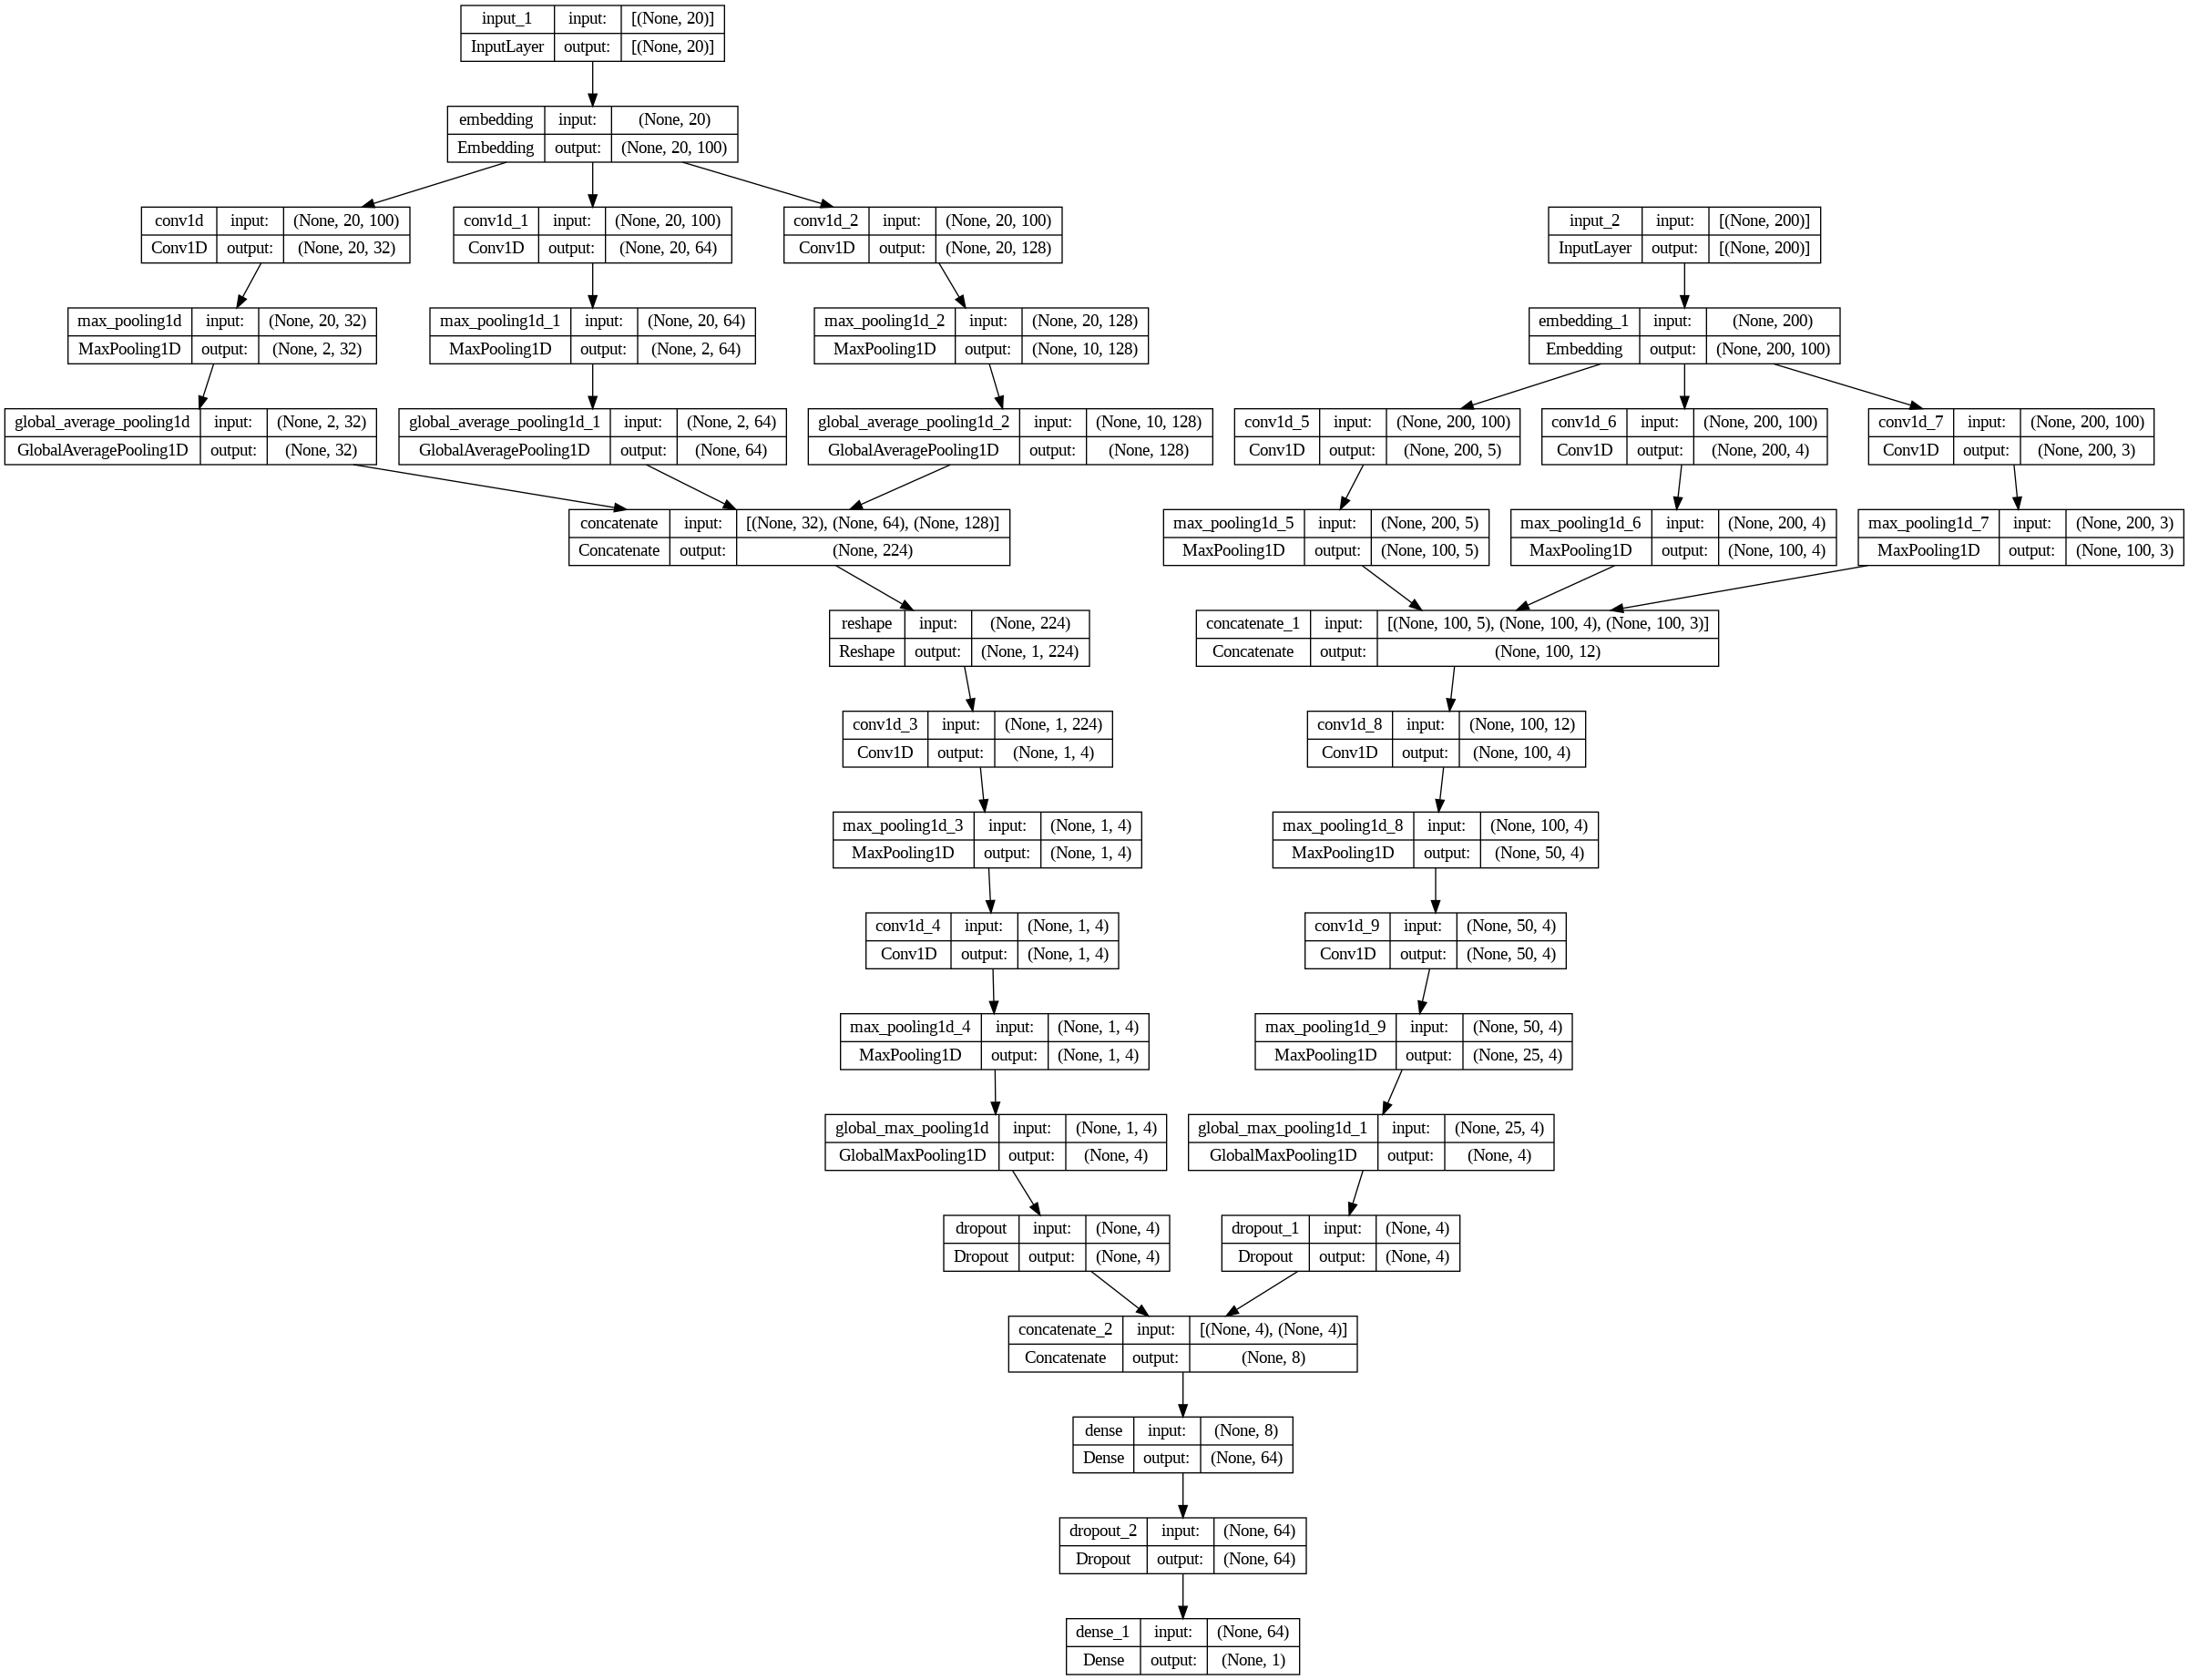

In [ ]:
# model.summary()
dot_img_file = '/content/drive/MyDrive/ST456-Final-Project/model_cnn.png'
tf.keras.utils.plot_model(model_cnn, to_file=dot_img_file, show_shapes=True)

In [ ]:
### Create the multi-input model
model_cnn = tf.keras.Model(inputs=[title_input, text_input], outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) 
model_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn= model_cnn.fit([x_train_title, x_train_text], y_train_text, validation_split = 0.2, epochs=50, batch_size=128)

Epoch 1/50
225/225 [==============================] - 83s 348ms/step - loss: 0.6371 - accuracy: 0.6658 - val_loss: 0.3599 - val_accuracy: 0.9012
Epoch 2/50
225/225 [==============================] - 76s 337ms/step - loss: 0.4076 - accuracy: 0.8240 - val_loss: 0.2407 - val_accuracy: 0.9308
Epoch 3/50
225/225 [==============================] - 80s 357ms/step - loss: 0.3423 - accuracy: 0.8598 - val_loss: 0.2297 - val_accuracy: 0.9346
Epoch 4/50
225/225 [==============================] - 75s 336ms/step - loss: 0.3024 - accuracy: 0.8776 - val_loss: 0.1717 - val_accuracy: 0.9502
Epoch 5/50
225/225 [==============================] - 79s 352ms/step - loss: 0.2687 - accuracy: 0.8888 - val_loss: 0.1377 - val_accuracy: 0.9580
Epoch 6/50
225/225 [==============================] - 75s 335ms/step - loss: 0.2308 - accuracy: 0.8994 - val_loss: 0.1102 - val_accuracy: 0.9655
Epoch 7/50
225/225 [==============================] - 75s 334ms/step - loss: 0.2140 - accuracy: 0.9069 - val_loss: 0.1018 - val_ac

In [ ]:
print("Accuracy of the model on Testing Data is - " , model_cnn.evaluate([x_test_title, x_test_text], y_test_text)[1]*100 , "%")

281/281 [==============================] - 7s 26ms/step - loss: 2.1628 - accuracy: 0.5482
Accuracy of the model on Testing Data is -  54.82182502746582 %


In [ ]:
loss_cnn = history_cnn.history['loss']
val_loss_cnn = history_cnn.history['val_loss']
acc_cnn = history_cnn.history['accuracy']
val_acc_cnn = history_cnn.history['val_accuracy']

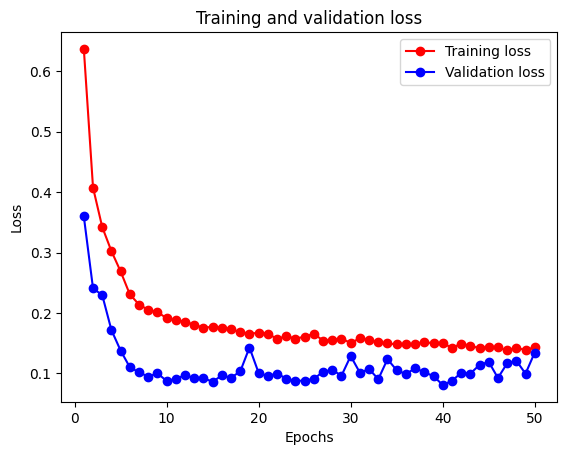

In [ ]:
epochs = range(1, 51)
plt.clf()
# plt.subplot(location)
plt.plot(epochs, loss_cnn, 'r-o', label='Training loss')
plt.plot(epochs, val_loss_cnn, 'b-o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

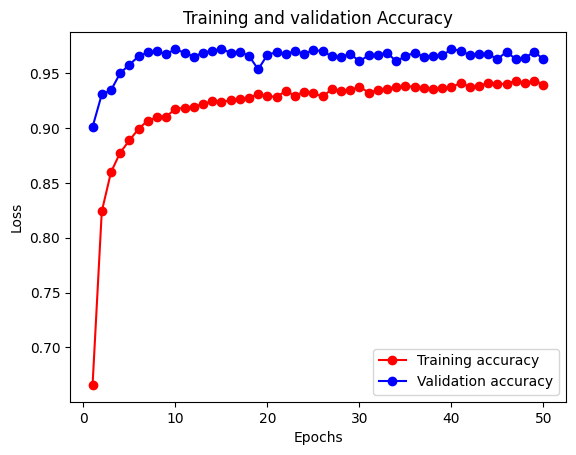

In [ ]:
epochs = range(1, 51)
plt.clf()
# plt.subplot(location)
plt.plot(epochs, acc_cnn, 'r-o', label='Training accuracy')
plt.plot(epochs, val_acc_cnn, 'b-o', label='Validation accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred_text = model_cnn.predict([x_test_title, x_test_text])
y_pred_text = [1 if x > 0.5 else 0 for x in y_pred_text]
#y_pred_text = [1 if x > 0.0005 else 0 for x in y_pred_text]
accuracy = accuracy_score(y_test_text, y_pred_text)
precision = precision_score(y_test_text, y_pred_text, average='macro')
recall = recall_score(y_test_text, y_pred_text, average='macro')
f1 = f1_score(y_test_text, y_pred_text, average='macro')
confusion = confusion_matrix(y_test_text, y_pred_text)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("Confusion matrix:\n", confusion)

281/281 [==============================] - 6s 21ms/step
Accuracy: 0.5482182628062361
Precision: 0.6764280626402016
Recall: 0.5321440810549057
F1 score: 0.4200923892261501
Confusion matrix:
 [[4572   78]
 [3979  351]]


## CNN Model(Adam: lr = 0.01, L1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D, Dropout, Bidirectional, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
#Model 2 - 74% lolz
#65% accuracy
#experimental model 
# Define input lengths for titles and texts
max_len1 = 20
max_len2 = 200
vocab_size1 = 20000 #19175
embedding_dim1 = 100
vocab_size2 = 110000 #108259
embedding_dim2 = 200
embedding_dim = 100
num_filters = 128
filter_size = 8
pool_size = 8
dropout_rate = 0.5


# Input for titles
title_input = tf.keras.Input(shape=(max_len1,))
title_embed = tf.keras.layers.Embedding(vocab_size, embedding_dim1, weights=[embedding_matrix], trainable=False)(title_input)
title_conv_1 = tf.keras.layers.Conv1D(32, 4, padding='same', activation='relu')(title_embed)
title_conv_2 = tf.keras.layers.Conv1D(64, 8, padding='same', activation='relu')(title_embed)
title_conv_3 = tf.keras.layers.Conv1D(128, 8, padding='same', activation='relu')(title_embed)

title_pool_1 = tf.keras.layers.MaxPooling1D(pool_size=pool_size)(title_conv_1)
title_pool_2 = tf.keras.layers.MaxPooling1D(pool_size=pool_size)(title_conv_2)
title_pool_3 = tf.keras.layers.MaxPooling1D(pool_size=2)(title_conv_3)

# Resize the inputs to have the same shape
title_pool_1 = tf.keras.layers.GlobalAveragePooling1D()(title_pool_1)
title_pool_2 = tf.keras.layers.GlobalAveragePooling1D()(title_pool_2)
title_pool_3 = tf.keras.layers.GlobalAveragePooling1D()(title_pool_3)

title_merged = tf.keras.layers.concatenate([title_pool_1, title_pool_2, title_pool_3])
title_merged = tf.keras.layers.Reshape((1, -1))(title_merged) 

title_conv = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu')(title_merged)
title_pool = tf.keras.layers.MaxPooling1D(pool_size=1)(title_conv)

title_conv1 = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu')(title_pool)
title_pool1 = tf.keras.layers.MaxPooling1D(pool_size=1)(title_conv1)

title_global_pool = tf.keras.layers.GlobalMaxPooling1D()(title_pool1)
title_drop = tf.keras.layers.Dropout(dropout_rate)(title_global_pool)

# Input for textsx
text_input = tf.keras.Input(shape=(max_len2,))
text_embed = tf.keras.layers.Embedding(vocab_size, embedding_dim1, weights=[embedding_matrix], trainable=False)(text_input)

text_conv_1 = tf.keras.layers.Conv1D(5, 8, padding='same', activation='relu')(text_embed)
text_conv_2 = tf.keras.layers.Conv1D(4, 8, padding='same', activation='relu')(text_embed)
text_conv_3 = tf.keras.layers.Conv1D(3, 4, padding='same', activation='relu')(text_embed)

text_pool_1 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv_1)
text_pool_2 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv_2)
text_pool_3 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv_3)

text_merged = tf.keras.layers.concatenate([text_pool_1, text_pool_2, text_pool_3])

text_conv = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu')(text_merged)
text_pool = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv)

text_conv1 = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu')(text_pool)
text_pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv1)

text_global_pool = tf.keras.layers.GlobalMaxPooling1D()(text_pool1)
text_drop = tf.keras.layers.Dropout(dropout_rate)(text_global_pool)

# Concatenate title and text representations
merged = tf.keras.layers.concatenate([title_drop, text_drop])

# Add additional layers for further processing
merged_dense = tf.keras.layers.Dense(64, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.01))(merged)
merged_drop = tf.keras.layers.Dropout(dropout_rate)(merged_dense)
output = tf.keras.layers.Dense(1, activation='sigmoid')(merged_drop)
# Create the multi-input model
model_cnn = tf.keras.Model(inputs=[title_input, text_input], outputs=output)
model_cnn.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 20, 100)      10870600    ['input_3[0][0]']                
                                                                                                  
 conv1d_10 (Conv1D)             (None, 20, 32)       12832       ['embedding_2[0][0]']            
                                                                                                  
 conv1d_11 (Conv1D)             (None, 20, 64)       51264       ['embedding_2[0][0]']            
                                                                                            

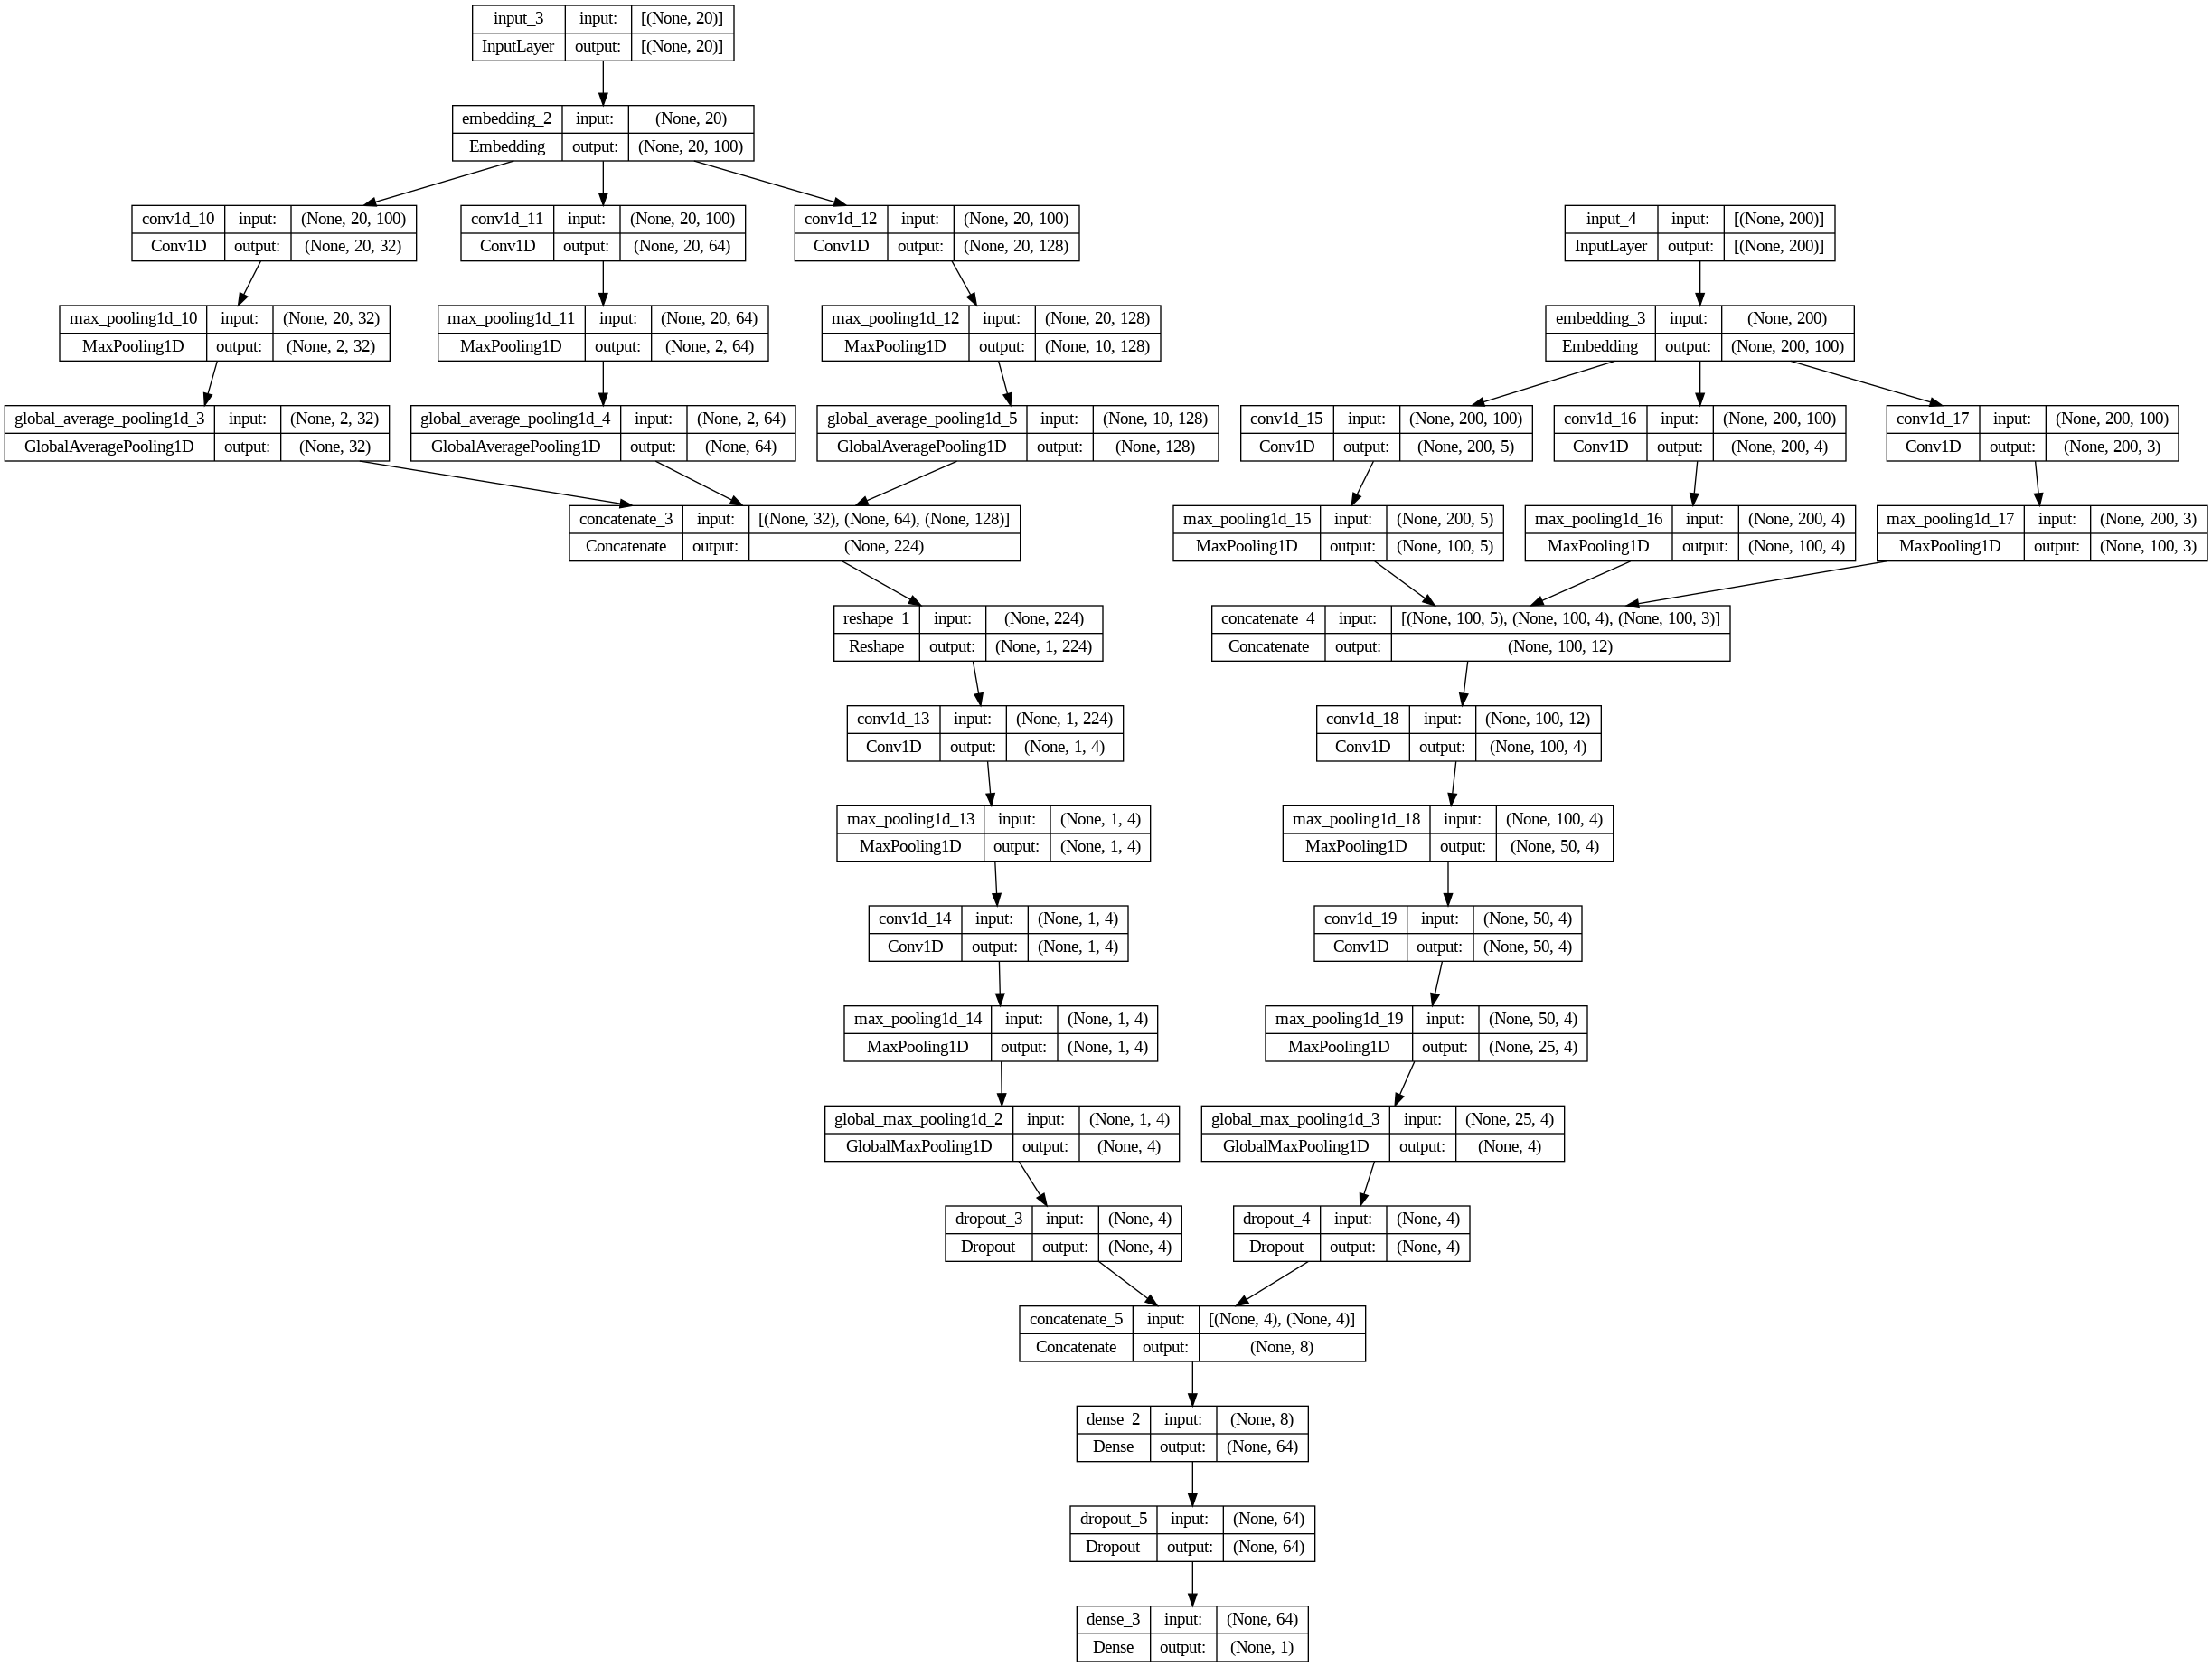

In [ ]:
# model.summary()
dot_img_file = '/content/drive/MyDrive/ST456-Final-Project/model_cnn.png'
tf.keras.utils.plot_model(model_cnn, to_file=dot_img_file, show_shapes=True)

In [ ]:
### Create the multi-input model
model_cnn = tf.keras.Model(inputs=[title_input, text_input], outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) 
model_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn= model_cnn.fit([x_train_title, x_train_text], y_train_text, validation_split = 0.2, epochs=50, batch_size=128)

Epoch 1/50
225/225 [==============================] - 78s 330ms/step - loss: 0.5950 - accuracy: 0.6607 - val_loss: 0.4534 - val_accuracy: 0.7858
Epoch 2/50
225/225 [==============================] - 72s 321ms/step - loss: 0.4725 - accuracy: 0.7830 - val_loss: 0.4076 - val_accuracy: 0.8274
Epoch 3/50
225/225 [==============================] - 72s 322ms/step - loss: 0.4304 - accuracy: 0.8150 - val_loss: 0.3175 - val_accuracy: 0.8790
Epoch 4/50
225/225 [==============================] - 72s 322ms/step - loss: 0.3644 - accuracy: 0.8603 - val_loss: 0.2303 - val_accuracy: 0.9220
Epoch 5/50
225/225 [==============================] - 71s 317ms/step - loss: 0.3011 - accuracy: 0.8967 - val_loss: 0.2029 - val_accuracy: 0.9303
Epoch 6/50
225/225 [==============================] - 71s 315ms/step - loss: 0.2731 - accuracy: 0.9098 - val_loss: 0.2023 - val_accuracy: 0.9294
Epoch 7/50
225/225 [==============================] - 74s 330ms/step - loss: 0.2555 - accuracy: 0.9173 - val_loss: 0.1890 - val_ac

In [ ]:
print("Accuracy of the model on Testing Data is - " , model_cnn.evaluate([x_test_title, x_test_text], y_test_text)[1]*100 , "%")

281/281 [==============================] - 6s 21ms/step - loss: 2.1954 - accuracy: 0.5004
Accuracy of the model on Testing Data is -  50.04454255104065 %


In [ ]:
loss_cnn = history_cnn.history['loss']
val_loss_cnn = history_cnn.history['val_loss']
acc_cnn = history_cnn.history['accuracy']
val_acc_cnn = history_cnn.history['val_accuracy']

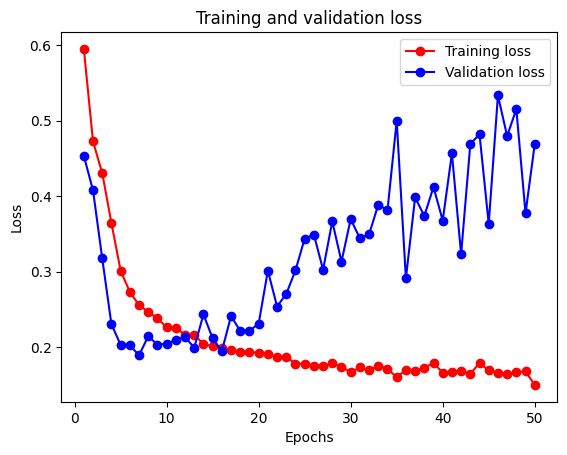

In [ ]:
epochs = range(1, 51)
plt.clf()
# plt.subplot(location)
plt.plot(epochs, loss_cnn, 'r-o', label='Training loss')
plt.plot(epochs, val_loss_cnn, 'b-o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

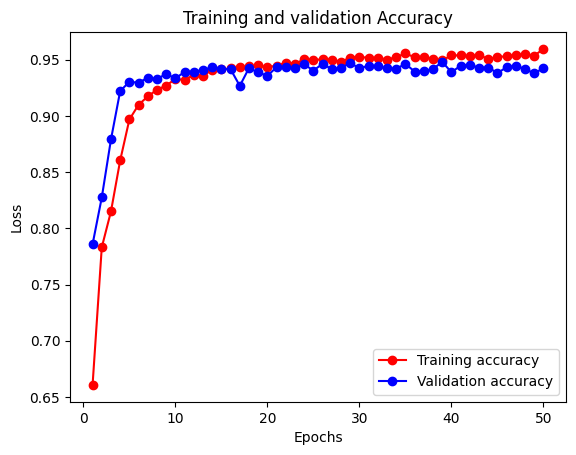

In [ ]:
epochs = range(1, 51)
plt.clf()
# plt.subplot(location)
plt.plot(epochs, acc_cnn, 'r-o', label='Training accuracy')
plt.plot(epochs, val_acc_cnn, 'b-o', label='Validation accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred_text = model_cnn.predict([x_test_title, x_test_text])
y_pred_text = [1 if x > 0.5 else 0 for x in y_pred_text]
#y_pred_text = [1 if x > 0.0005 else 0 for x in y_pred_text]
accuracy = accuracy_score(y_test_text, y_pred_text)
precision = precision_score(y_test_text, y_pred_text, average='macro')
recall = recall_score(y_test_text, y_pred_text, average='macro')
f1 = f1_score(y_test_text, y_pred_text, average='macro')
confusion = confusion_matrix(y_test_text, y_pred_text)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("Confusion matrix:\n", confusion)

281/281 [==============================] - 8s 28ms/step
Accuracy: 0.500445434298441
Precision: 0.2879924242424242
Recall: 0.48332116516427026
F1 score: 0.3358949546237605
Confusion matrix:
 [[4482  168]
 [4318   12]]


## CNN Model(Adam: lr = 0.0001, L2)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D, Dropout, Bidirectional, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
#Model 2 - 74% lolz
#65% accuracy
#experimental model 
# Define input lengths for titles and texts
max_len1 = 20
max_len2 = 200
vocab_size1 = 20000 #19175
embedding_dim1 = 100
vocab_size2 = 110000 #108259
embedding_dim2 = 200
embedding_dim = 100
num_filters = 128
filter_size = 8
pool_size = 8
dropout_rate = 0.5


# Input for titles
title_input = tf.keras.Input(shape=(max_len1,))
title_embed = tf.keras.layers.Embedding(vocab_size, embedding_dim1, weights=[embedding_matrix], trainable=False)(title_input)
title_conv_1 = tf.keras.layers.Conv1D(32, 4, padding='same', activation='relu', kernel_regularizer = l2(0.01))(title_embed)
title_conv_2 = tf.keras.layers.Conv1D(64, 8, padding='same', activation='relu', kernel_regularizer = l2(0.01))(title_embed)
title_conv_3 = tf.keras.layers.Conv1D(128, 8, padding='same', activation='relu', kernel_regularizer = l2(0.01))(title_embed)

title_pool_1 = tf.keras.layers.MaxPooling1D(pool_size=pool_size)(title_conv_1)
title_pool_2 = tf.keras.layers.MaxPooling1D(pool_size=pool_size)(title_conv_2)
title_pool_3 = tf.keras.layers.MaxPooling1D(pool_size=2)(title_conv_3)

# Resize the inputs to have the same shape
title_pool_1 = tf.keras.layers.GlobalAveragePooling1D()(title_pool_1)
title_pool_2 = tf.keras.layers.GlobalAveragePooling1D()(title_pool_2)
title_pool_3 = tf.keras.layers.GlobalAveragePooling1D()(title_pool_3)

title_merged = tf.keras.layers.concatenate([title_pool_1, title_pool_2, title_pool_3])
title_merged = tf.keras.layers.Reshape((1, -1))(title_merged) 

title_conv = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu', kernel_regularizer= l2(0.01))(title_merged)
title_pool = tf.keras.layers.MaxPooling1D(pool_size=1)(title_conv)

title_conv1 = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu', kernel_regularizer = l2(0.01))(title_pool)
title_pool1 = tf.keras.layers.MaxPooling1D(pool_size=1)(title_conv1)

title_global_pool = tf.keras.layers.GlobalMaxPooling1D()(title_pool1)
title_drop = tf.keras.layers.Dropout(dropout_rate)(title_global_pool)

# Input for textsx
text_input = tf.keras.Input(shape=(max_len2,))
text_embed = tf.keras.layers.Embedding(vocab_size, embedding_dim1, weights=[embedding_matrix], trainable=False)(text_input)

text_conv_1 = tf.keras.layers.Conv1D(5, 8, padding='same', activation='relu', kernel_regularizer = l2(0.01))(text_embed)
text_conv_2 = tf.keras.layers.Conv1D(4, 8, padding='same', activation='relu', kernel_regularizer = l2(0.01))(text_embed)
text_conv_3 = tf.keras.layers.Conv1D(3, 4, padding='same', activation='relu', kernel_regularizer = l2(0.01))(text_embed)

text_pool_1 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv_1)
text_pool_2 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv_2)
text_pool_3 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv_3)

text_merged = tf.keras.layers.concatenate([text_pool_1, text_pool_2, text_pool_3])

text_conv = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu', kernel_regularizer = l2(0.01))(text_merged)
text_pool = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv)

text_conv1 = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu', kernel_regularizer = l2(0.01))(text_pool)
text_pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv1)

text_global_pool = tf.keras.layers.GlobalMaxPooling1D()(text_pool1)
text_drop = tf.keras.layers.Dropout(dropout_rate)(text_global_pool)

# Concatenate title and text representations
merged = tf.keras.layers.concatenate([title_drop, text_drop])

# Add additional layers for further processing
merged_dense = tf.keras.layers.Dense(64, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.01))(merged)
merged_drop = tf.keras.layers.Dropout(dropout_rate)(merged_dense)
output = tf.keras.layers.Dense(1, activation='sigmoid')(merged_drop)
# Create the multi-input model
model_cnn = tf.keras.Model(inputs=[title_input, text_input], outputs=output)
model_cnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 20, 100)      10870600    ['input_4[0][0]']                
                                                                                                  
 conv1d_10 (Conv1D)             (None, 20, 32)       12832       ['embedding_3[0][0]']            
                                                                                                  
 conv1d_11 (Conv1D)             (None, 20, 64)       51264       ['embedding_3[0][0]']            
                                                                                            

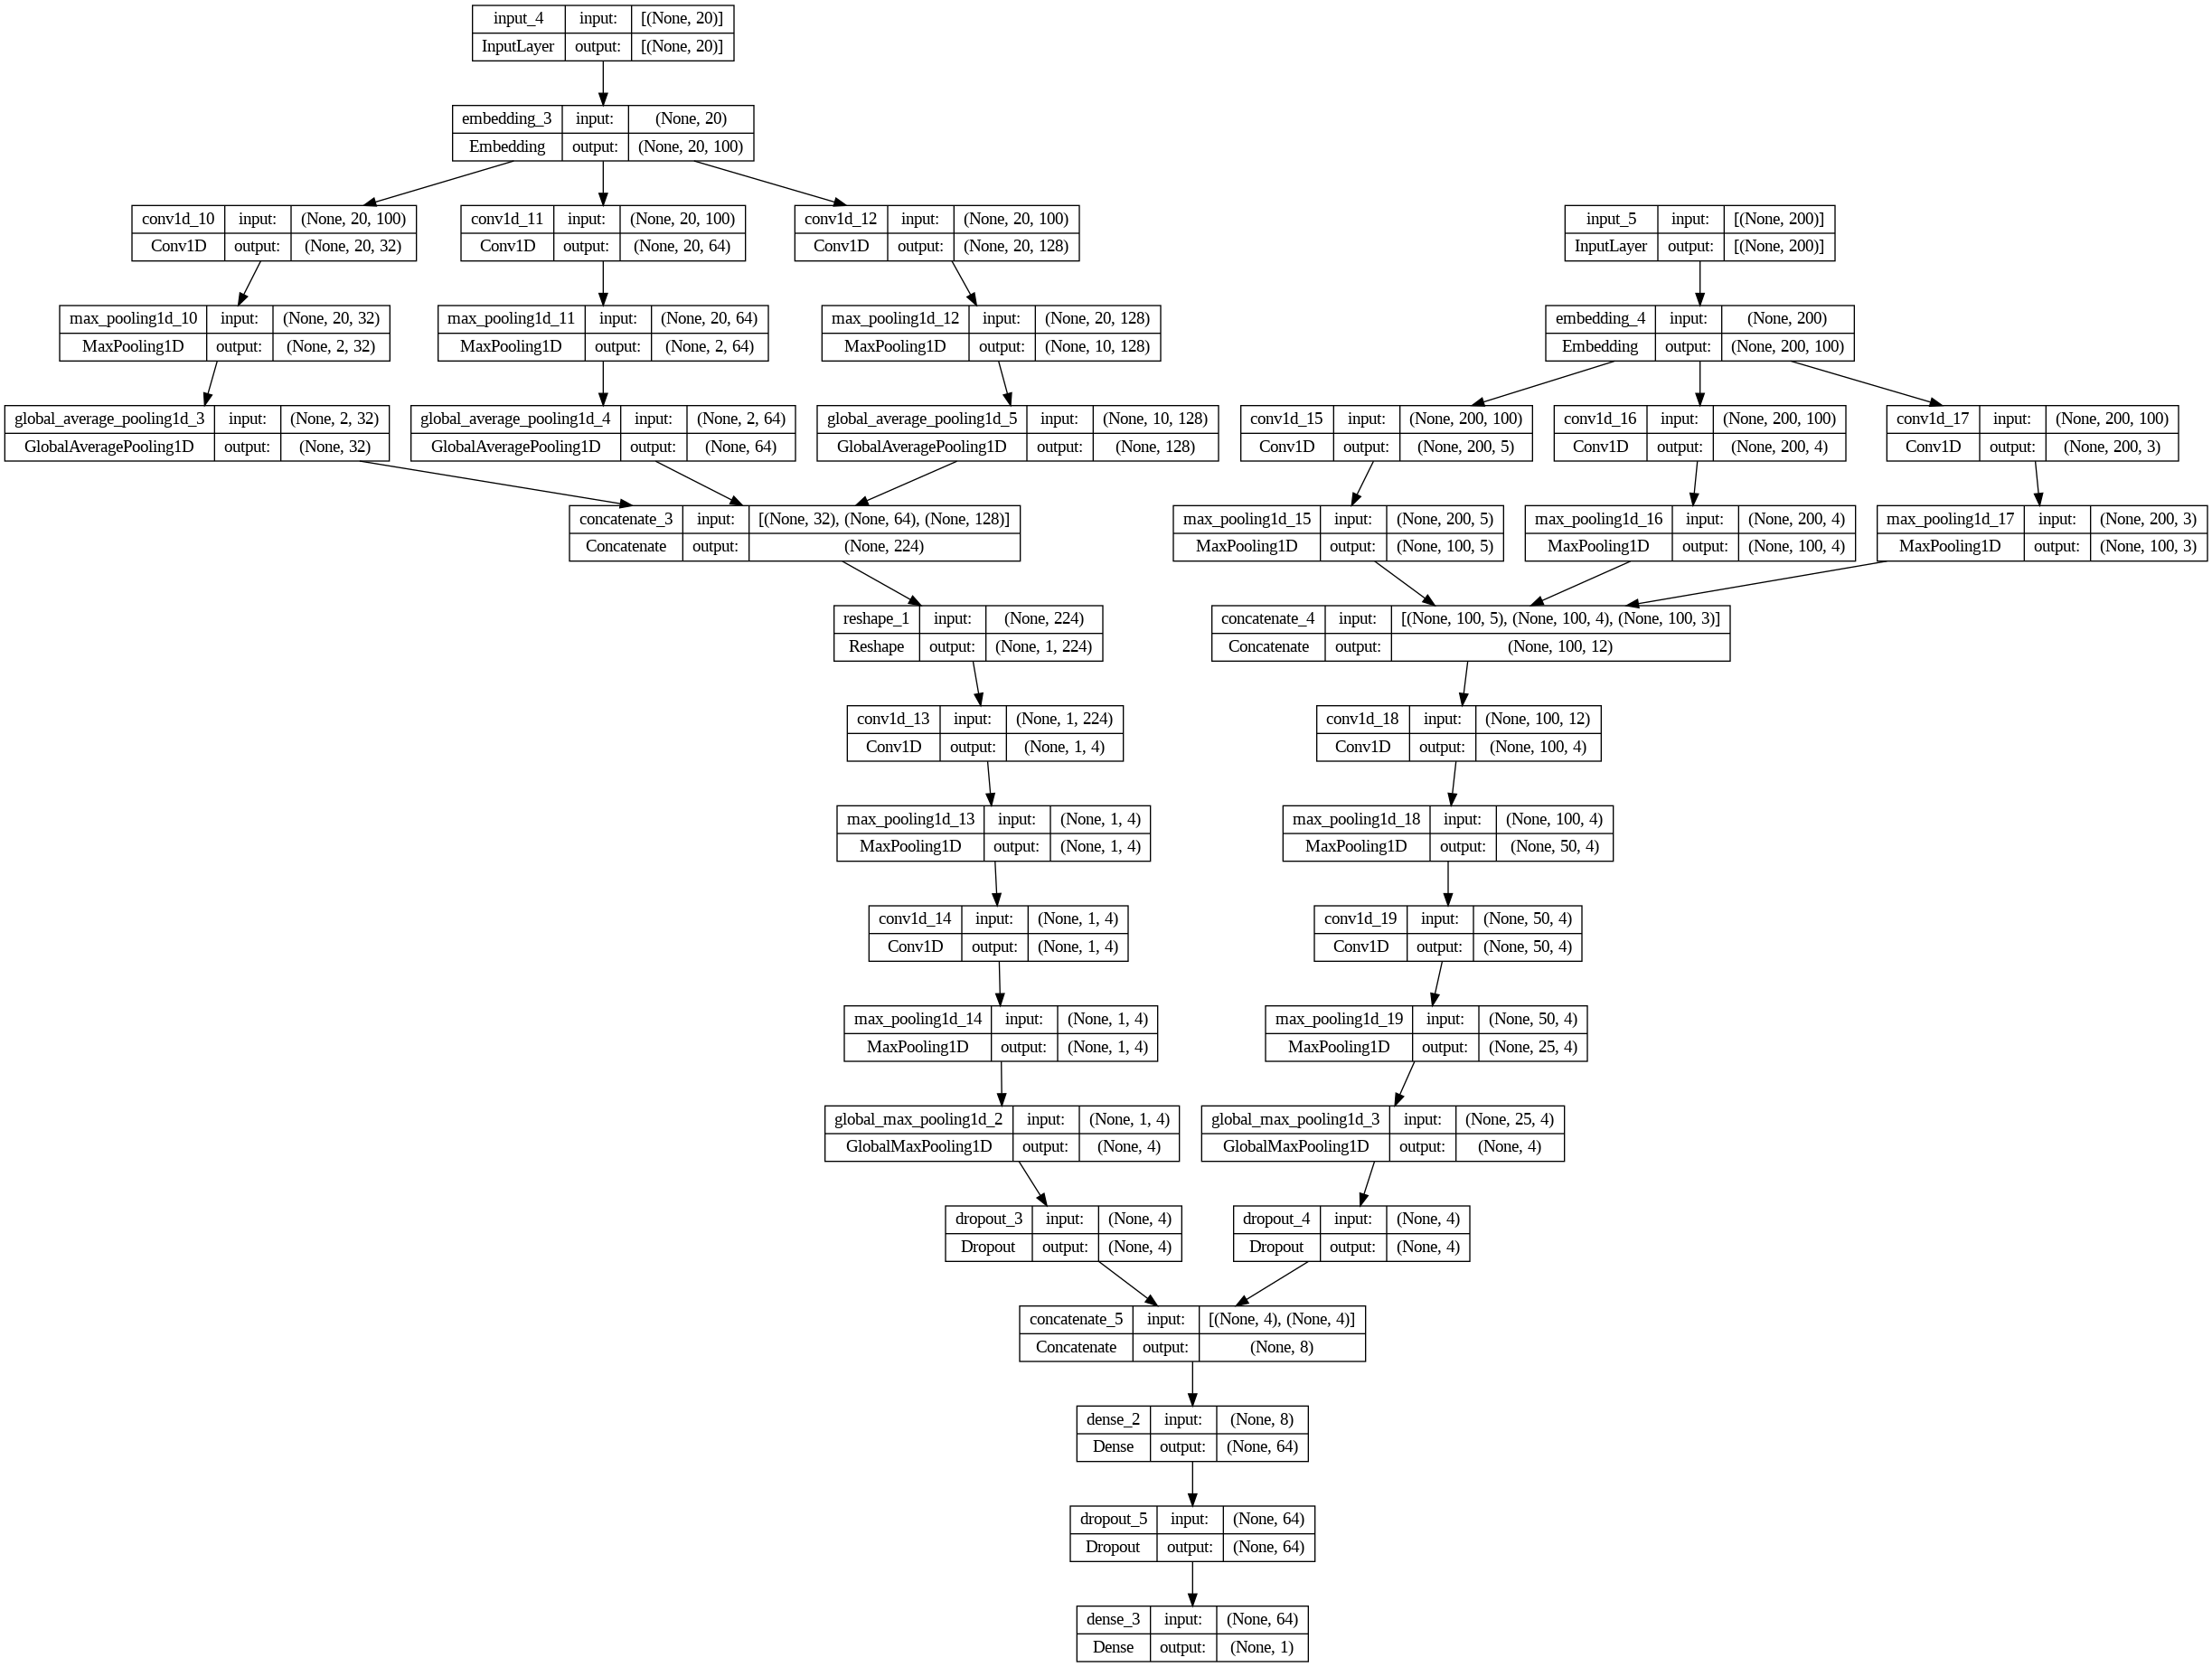

In [ ]:
# model.summary()
dot_img_file = '/content/drive/MyDrive/ST456-Final-Project/model_cnn.png'
tf.keras.utils.plot_model(model_cnn, to_file=dot_img_file, show_shapes=True)

In [ ]:
### Create the multi-input model
model_cnn = tf.keras.Model(inputs=[title_input, text_input], outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) 
model_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn= model_cnn.fit([x_train_title, x_train_text], y_train_text, validation_split = 0.2, epochs=50, batch_size=128)

Epoch 1/50
225/225 [==============================] - 90s 380ms/step - loss: 2.7157 - accuracy: 0.5139 - val_loss: 1.9852 - val_accuracy: 0.5195
Epoch 2/50
225/225 [==============================] - 81s 359ms/step - loss: 1.5997 - accuracy: 0.5230 - val_loss: 1.3073 - val_accuracy: 0.5193
Epoch 3/50
225/225 [==============================] - 86s 380ms/step - loss: 1.1427 - accuracy: 0.5463 - val_loss: 1.0020 - val_accuracy: 0.5689
Epoch 4/50
225/225 [==============================] - 79s 352ms/step - loss: 0.9024 - accuracy: 0.6793 - val_loss: 0.7962 - val_accuracy: 0.8039
Epoch 5/50
225/225 [==============================] - 84s 375ms/step - loss: 0.7622 - accuracy: 0.7807 - val_loss: 0.6821 - val_accuracy: 0.8551
Epoch 6/50
225/225 [==============================] - 80s 354ms/step - loss: 0.6854 - accuracy: 0.8117 - val_loss: 0.6117 - val_accuracy: 0.8731
Epoch 7/50
225/225 [==============================] - 78s 349ms/step - loss: 0.6305 - accuracy: 0.8240 - val_loss: 0.5601 - val_ac

In [ ]:
print("Accuracy of the model on Testing Data is - " , model_cnn.evaluate([x_test_title, x_test_text], y_test_text)[1]*100 , "%")

281/281 [==============================] - 7s 23ms/step - loss: 0.5829 - accuracy: 0.7895
Accuracy of the model on Testing Data is -  78.95323038101196 %


In [ ]:
loss_cnn = history_cnn.history['loss']
val_loss_cnn = history_cnn.history['val_loss']
acc_cnn = history_cnn.history['accuracy']
val_acc_cnn = history_cnn.history['val_accuracy']

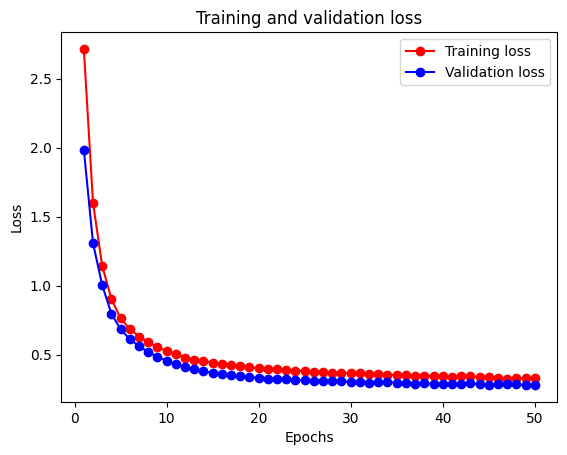

In [ ]:
epochs = range(1, 51)
plt.clf()
# plt.subplot(location)
plt.plot(epochs, loss_cnn, 'r-o', label='Training loss')
plt.plot(epochs, val_loss_cnn, 'b-o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

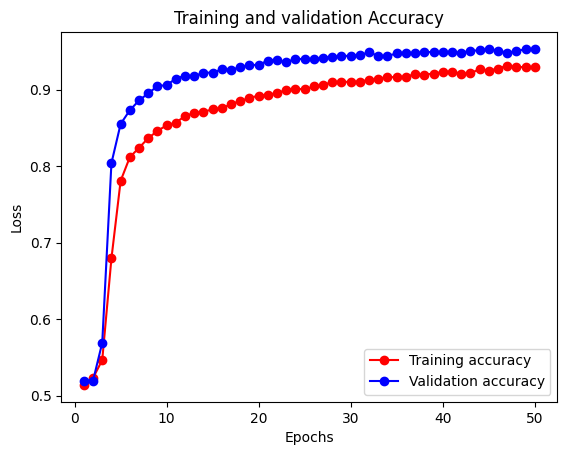

In [ ]:
epochs = range(1, 51)
plt.clf()
# plt.subplot(location)
plt.plot(epochs, acc_cnn, 'r-o', label='Training accuracy')
plt.plot(epochs, val_acc_cnn, 'b-o', label='Validation accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred_text = model_cnn.predict([x_test_title, x_test_text])
y_pred_text = [1 if x > 0.5 else 0 for x in y_pred_text]
#y_pred_text = [1 if x > 0.0005 else 0 for x in y_pred_text]
accuracy = accuracy_score(y_test_text, y_pred_text)
precision = precision_score(y_test_text, y_pred_text, average='macro')
recall = recall_score(y_test_text, y_pred_text, average='macro')
f1 = f1_score(y_test_text, y_pred_text, average='macro')
confusion = confusion_matrix(y_test_text, y_pred_text)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("Confusion matrix:\n", confusion)

281/281 [==============================] - 9s 31ms/step
Accuracy: 0.7895322939866369
Precision: 0.8076037460763396
Recall: 0.7937386078621271
F1 score: 0.7878230041658311
Confusion matrix:
 [[3142 1508]
 [ 382 3948]]


## CNN Model(SGD: lr = 0.0001, L1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D, Dropout, Bidirectional, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
#Model 2 - 74% lolz
#65% accuracy
#experimental model 
# Define input lengths for titles and texts
max_len1 = 20
max_len2 = 200
vocab_size1 = 20000 #19175
embedding_dim1 = 100
vocab_size2 = 110000 #108259
embedding_dim2 = 200
embedding_dim = 100
num_filters = 128
filter_size = 8
pool_size = 8
dropout_rate = 0.5


# Input for titles
title_input = tf.keras.Input(shape=(max_len1,))
title_embed = tf.keras.layers.Embedding(vocab_size, embedding_dim1, weights=[embedding_matrix], trainable=False)(title_input)
title_conv_1 = tf.keras.layers.Conv1D(32, 4, padding='same', activation='relu')(title_embed)
title_conv_2 = tf.keras.layers.Conv1D(64, 8, padding='same', activation='relu')(title_embed)
title_conv_3 = tf.keras.layers.Conv1D(128, 8, padding='same', activation='relu')(title_embed)

title_pool_1 = tf.keras.layers.MaxPooling1D(pool_size=pool_size)(title_conv_1)
title_pool_2 = tf.keras.layers.MaxPooling1D(pool_size=pool_size)(title_conv_2)
title_pool_3 = tf.keras.layers.MaxPooling1D(pool_size=2)(title_conv_3)

# Resize the inputs to have the same shape
title_pool_1 = tf.keras.layers.GlobalAveragePooling1D()(title_pool_1)
title_pool_2 = tf.keras.layers.GlobalAveragePooling1D()(title_pool_2)
title_pool_3 = tf.keras.layers.GlobalAveragePooling1D()(title_pool_3)

title_merged = tf.keras.layers.concatenate([title_pool_1, title_pool_2, title_pool_3])
title_merged = tf.keras.layers.Reshape((1, -1))(title_merged) 

title_conv = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu')(title_merged)
title_pool = tf.keras.layers.MaxPooling1D(pool_size=1)(title_conv)

title_conv1 = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu')(title_pool)
title_pool1 = tf.keras.layers.MaxPooling1D(pool_size=1)(title_conv1)

title_global_pool = tf.keras.layers.GlobalMaxPooling1D()(title_pool1)
title_drop = tf.keras.layers.Dropout(dropout_rate)(title_global_pool)

# Input for textsx
text_input = tf.keras.Input(shape=(max_len2,))
text_embed = tf.keras.layers.Embedding(vocab_size, embedding_dim1, weights=[embedding_matrix], trainable=False)(text_input)

text_conv_1 = tf.keras.layers.Conv1D(5, 8, padding='same', activation='relu')(text_embed)
text_conv_2 = tf.keras.layers.Conv1D(4, 8, padding='same', activation='relu')(text_embed)
text_conv_3 = tf.keras.layers.Conv1D(3, 4, padding='same', activation='relu')(text_embed)

text_pool_1 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv_1)
text_pool_2 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv_2)
text_pool_3 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv_3)

text_merged = tf.keras.layers.concatenate([text_pool_1, text_pool_2, text_pool_3])

text_conv = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu')(text_merged)
text_pool = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv)

text_conv1 = tf.keras.layers.Conv1D(4, 4, padding='same', activation='relu')(text_pool)
text_pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(text_conv1)

text_global_pool = tf.keras.layers.GlobalMaxPooling1D()(text_pool1)
text_drop = tf.keras.layers.Dropout(dropout_rate)(text_global_pool)

# Concatenate title and text representations
merged = tf.keras.layers.concatenate([title_drop, text_drop])

# Add additional layers for further processing
merged_dense = tf.keras.layers.Dense(64, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.01))(merged)
merged_drop = tf.keras.layers.Dropout(dropout_rate)(merged_dense)
output = tf.keras.layers.Dense(1, activation='sigmoid')(merged_drop)
# Create the multi-input model
model_cnn = tf.keras.Model(inputs=[title_input, text_input], outputs=output)
model_cnn.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 20, 100)      10870600    ['input_6[0][0]']                
                                                                                                  
 conv1d_20 (Conv1D)             (None, 20, 32)       12832       ['embedding_5[0][0]']            
                                                                                                  
 conv1d_21 (Conv1D)             (None, 20, 64)       51264       ['embedding_5[0][0]']            
                                                                                            

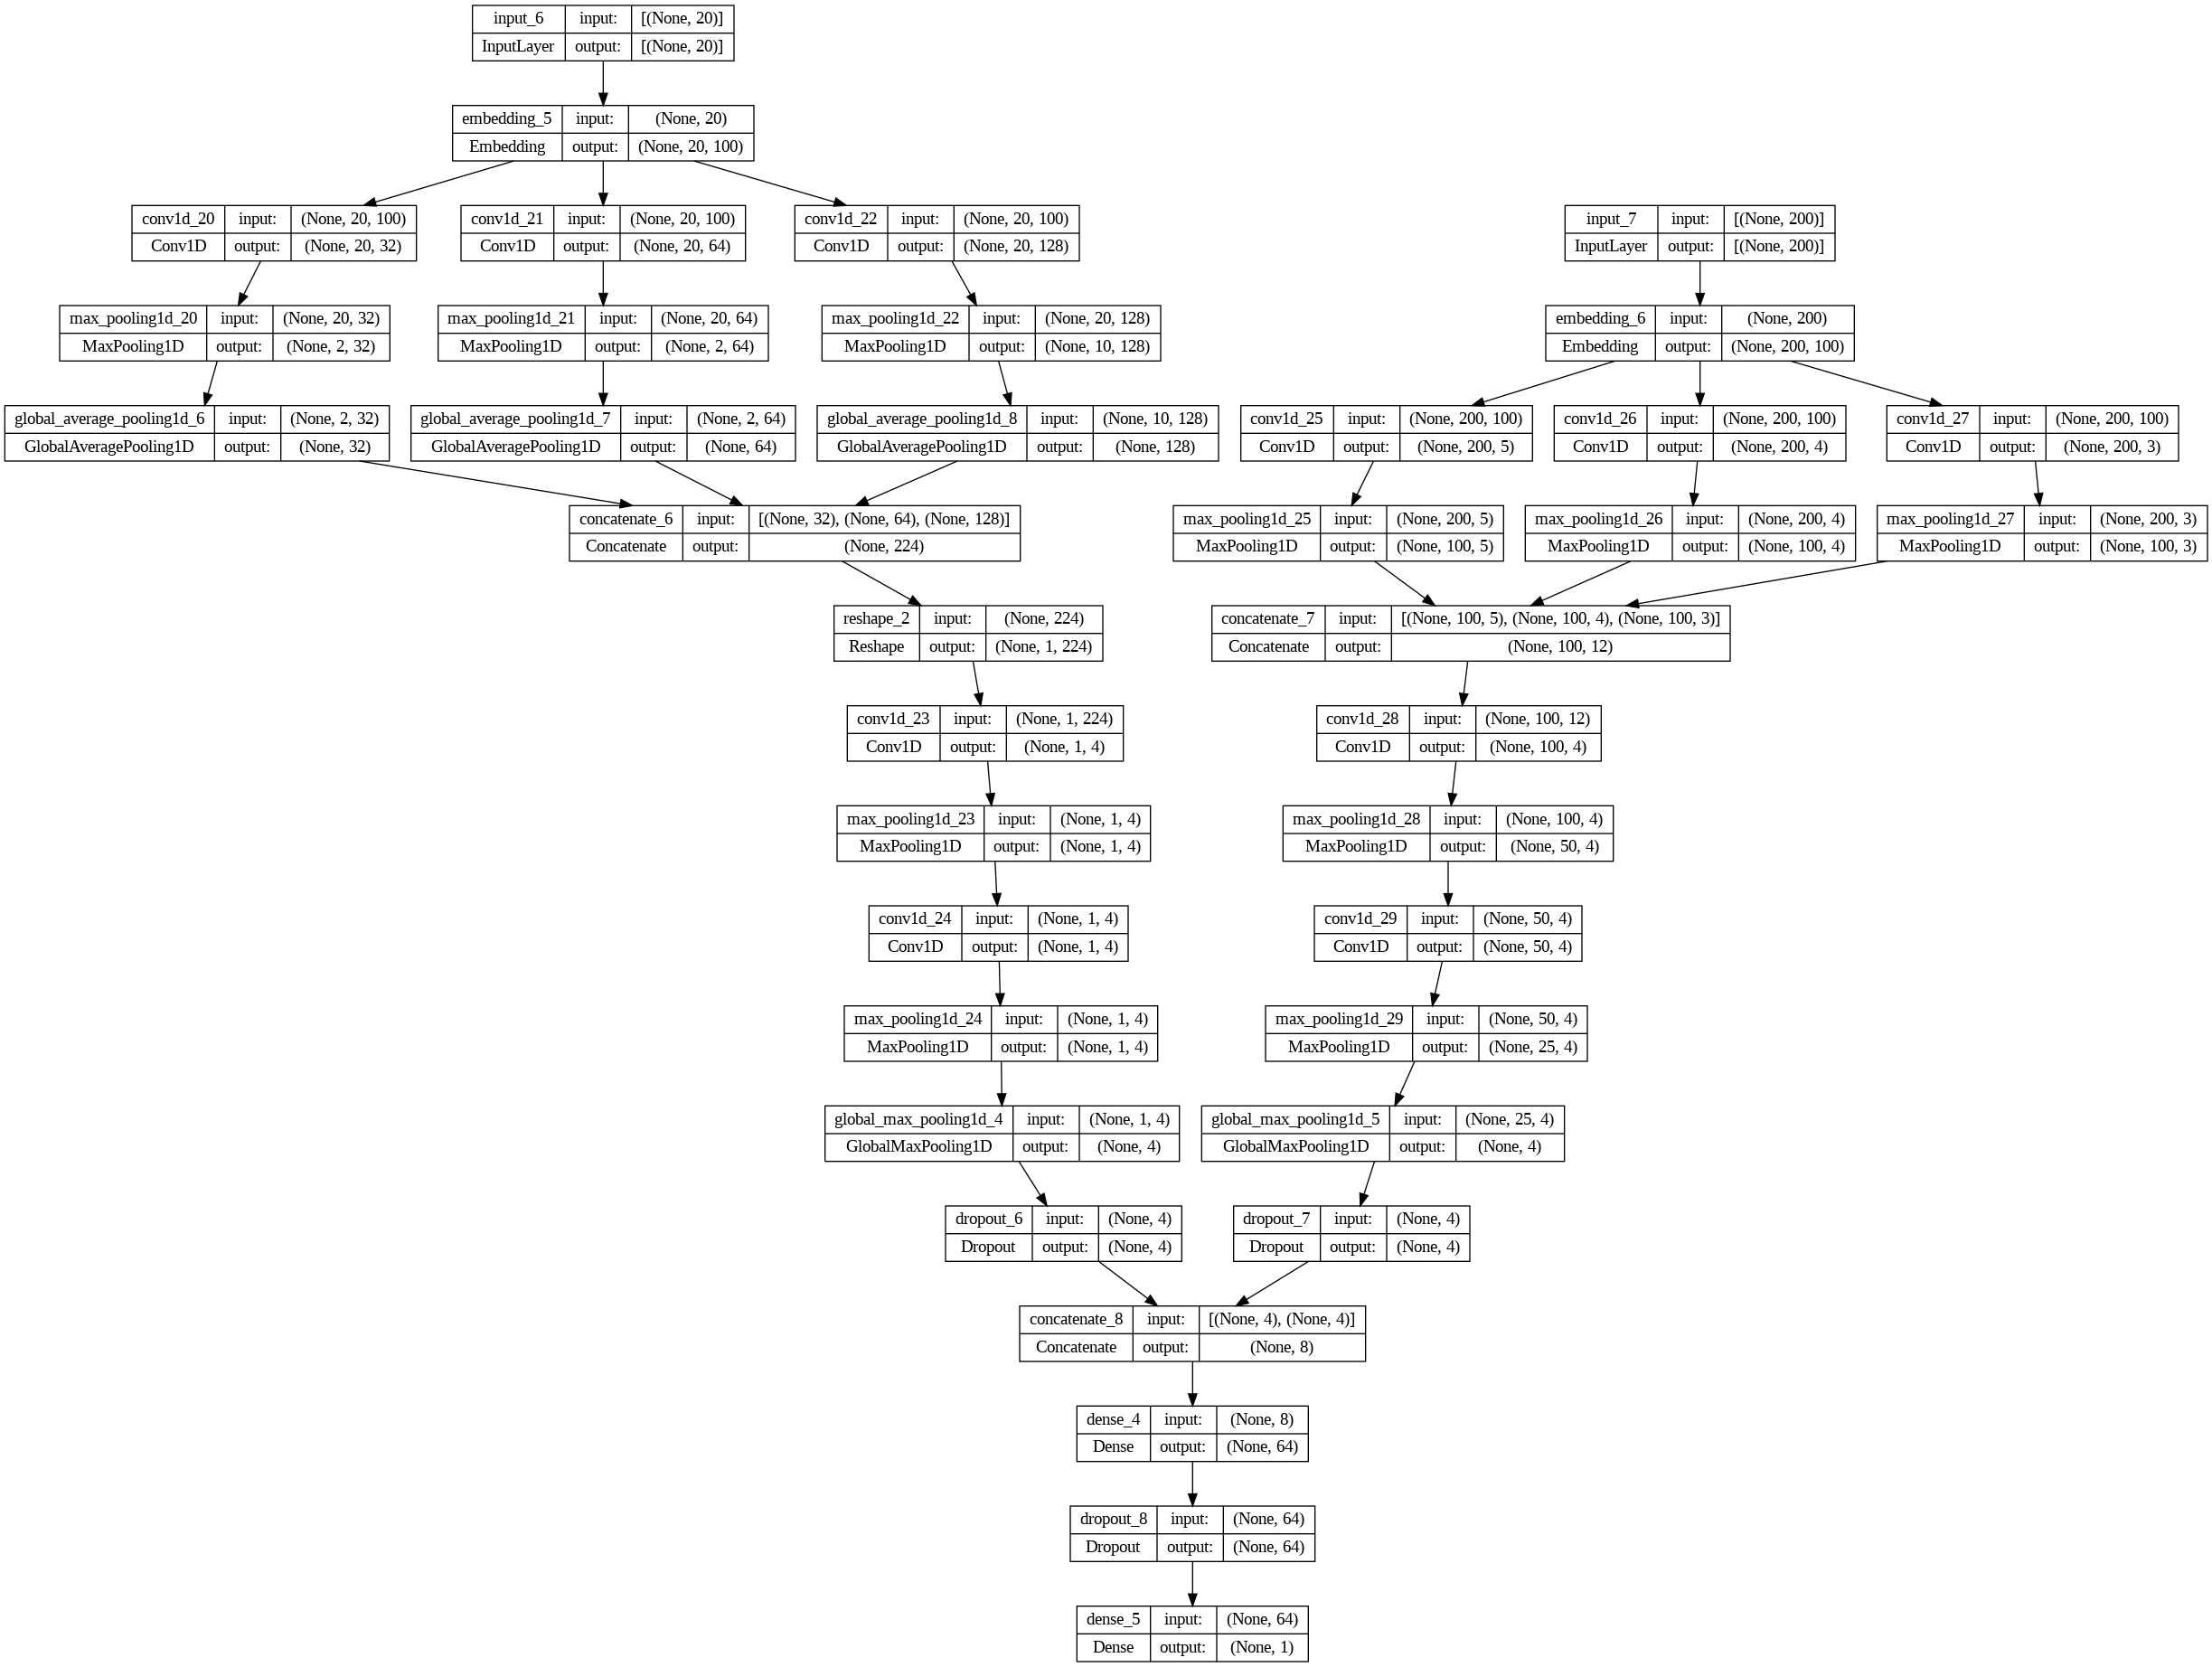

In [ ]:
# model.summary()
dot_img_file = '/content/drive/MyDrive/ST456-Final-Project/model_cnn.png'
tf.keras.utils.plot_model(model_cnn, to_file=dot_img_file, show_shapes=True)

In [ ]:
### Create the multi-input model
model_cnn = tf.keras.Model(inputs=[title_input, text_input], outputs=output)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001) 
model_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn= model_cnn.fit([x_train_title, x_train_text], y_train_text, validation_split = 0.2, epochs=50, batch_size=128)

Epoch 1/50
225/225 [==============================] - 90s 390ms/step - loss: 0.8565 - accuracy: 0.5113 - val_loss: 0.8406 - val_accuracy: 0.5043
Epoch 2/50
225/225 [==============================] - 82s 364ms/step - loss: 0.8562 - accuracy: 0.5042 - val_loss: 0.8390 - val_accuracy: 0.5038
Epoch 3/50
225/225 [==============================] - 89s 395ms/step - loss: 0.8534 - accuracy: 0.5088 - val_loss: 0.8376 - val_accuracy: 0.5032
Epoch 4/50
225/225 [==============================] - 81s 360ms/step - loss: 0.8510 - accuracy: 0.5122 - val_loss: 0.8365 - val_accuracy: 0.5029
Epoch 5/50
225/225 [==============================] - 82s 363ms/step - loss: 0.8478 - accuracy: 0.5103 - val_loss: 0.8355 - val_accuracy: 0.5028
Epoch 6/50
225/225 [==============================] - 81s 361ms/step - loss: 0.8492 - accuracy: 0.5058 - val_loss: 0.8346 - val_accuracy: 0.5021
Epoch 7/50
225/225 [==============================] - 82s 366ms/step - loss: 0.8460 - accuracy: 0.5071 - val_loss: 0.8338 - val_ac

In [ ]:
print("Accuracy of the model on Testing Data is - " , model_cnn.evaluate([x_test_title, x_test_text], y_test_text)[1]*100 , "%")

281/281 [==============================] - 6s 23ms/step - loss: 0.8223 - accuracy: 0.5320
Accuracy of the model on Testing Data is -  53.19598913192749 %


In [ ]:
loss_cnn = history_cnn.history['loss']
val_loss_cnn = history_cnn.history['val_loss']
acc_cnn = history_cnn.history['accuracy']
val_acc_cnn = history_cnn.history['val_accuracy']

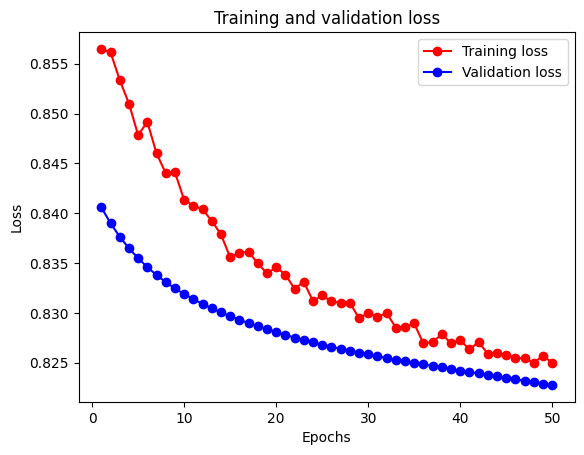

In [ ]:
epochs = range(1, 51)
plt.clf()
# plt.subplot(location)
plt.plot(epochs, loss_cnn, 'r-o', label='Training loss')
plt.plot(epochs, val_loss_cnn, 'b-o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

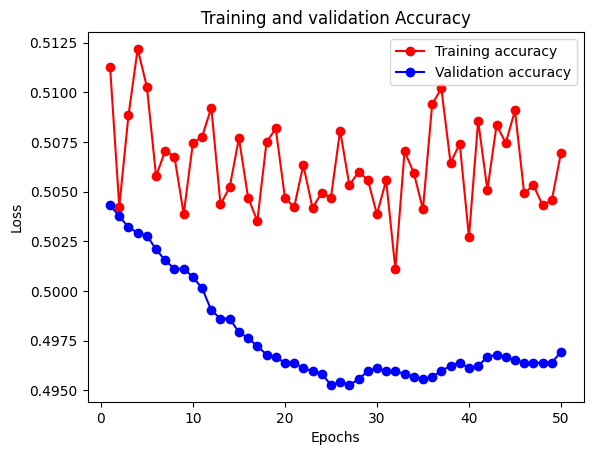

In [ ]:
epochs = range(1, 51)
plt.clf()
# plt.subplot(location)
plt.plot(epochs, acc_cnn, 'r-o', label='Training accuracy')
plt.plot(epochs, val_acc_cnn, 'b-o', label='Validation accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred_text = model_cnn.predict([x_test_title, x_test_text])
y_pred_text = [1 if x > 0.5 else 0 for x in y_pred_text]
#y_pred_text = [1 if x > 0.0005 else 0 for x in y_pred_text]
accuracy = accuracy_score(y_test_text, y_pred_text)
precision = precision_score(y_test_text, y_pred_text, average='macro')
recall = recall_score(y_test_text, y_pred_text, average='macro')
f1 = f1_score(y_test_text, y_pred_text, average='macro')
confusion = confusion_matrix(y_test_text, y_pred_text)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("Confusion matrix:\n", confusion)

281/281 [==============================] - 7s 22ms/step
Accuracy: 0.5319599109131403
Precision: 0.5350084487645825
Recall: 0.5344123271002508
F1 score: 0.5307973309146872
Confusion matrix:
 [[2165 2485]
 [1718 2612]]
